In [1]:
import numpy as np
float_formatter=lambda x: "%.3f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
from skimage.io import imread
from skimage.color import rgb2hsv
from matplotlib import pyplot as plt
from sklearn.cluster import SpectralClustering, KMeans

In [2]:
numPartition=2         # number of classes in the segmented image
maxDist=1              # in the graph of the image, add edge between pixels within distance maxDist 
                       # in this program, only maxDist=1 is used. If provided > 1 values, the distance will be calculated in one direction
                       # only. e.g. if maxDist=2, then distance 2 in horizontal, vertical and diagonal directions will be considered,
                       # but not 1 horizontal+1diagonal. 
                       # This variable is kept for future implementation of distance calculation based on 8 neighborhood.
varianceHue=0.001      # within class variance of hue
varianceIntensity=2    # within class variance of intensity
varianceDistance=5     # within class variance of distance

In [3]:
def createImage(dim):
    '''
    Create an image with dimensions passed through the argument
    '''
    img=np.zeros(dim)
    r,c,_=dim
   
    for i in range(r):
      for j in range(c):
        if j>(c//2):
          img[i,j,0]=1
        else:        
          img[i,j,2]=1
    
    return img

In [4]:
def getVectorDistance(img,direction=0,dist=1):
    '''
    Calculates the distance between two neighboring pixels in an image, in the vector form (after applying stacking operator)
    inputs:
        img       -> a single channel of image
        dist      -> distance between the vertices in the image
                     default is 1
        direction -> direction of neighborhood
                     0 : horizontal
                     1 : vertical
                     2 : diagonal
                     3 : cross diagonal
                     Default is 0 (horizontal).
  
    '''
    c=img.shape[1]              # get number of columns of the image matrix
    
    ## calculate distance between the pixels in the vector form of the image.
    if direction == 1:          # in vertical direction          
        d=dist*c 
    elif direction == 2:        # in diagonal direction
        d=dist*(c+1)
    elif direction == 3:        # in cross-diagonal direction
        d=dist*(c-1)
    else:                       # in horizontal direction
        d=dist
    return c,d

In [5]:
def calcChannelWeight(img,dist,variance,hue=False,direction=0):
    '''
    Calculates the weights, corresponding to the channel passed in input, of edges of the image graph.
    inputs:
        img       -> a single channel of image, generally hue or intensity
        dist      -> distance between the vertices 
        variance  -> variance of the channel accepted for similar vertices. 
        hue       -> set to True if the input channel is a hue channel, or else set to False.
                     Used to eliminate discontinuity, hence high differences in hue at 0 degree and 360 degrees.
                     default is False.
        direction -> direction of neighborhood. i.e. calculate weights of horizontal/vertical/diagonal/cross-diagonal edges.
                     0 : horizontal
                     1 : vertical
                     2 : diagonal
                     3 : cross diagonal
                     Default is 0 (horizontal).
    output :
        img2      -> An array of dimension n-2, where n is the number of pixels in input img
                     values popuated as (x1 - x2)^2/variance,
                     where x1 corresponds to each pixel in img, and x2 is the pixel d steps down to it. 
                     This vector will be set diagonally to the adjacency matrix, after adding elements from all channels.
    '''
    c,d=getVectorDistance(img,direction,dist)
        
    img0=img.flatten()          # Applying stacking operator to get a single vector from the image matrix 
    img1=img0[:(-1*d)]          # getting x2 to calculate x1-x2
    img0=img0[d:]               # getting rid of d first pixels from x1 as x1-d th position is out of image border for them 
    img2=np.abs(img0-img1)      # x1-x2

    if hue:                     # adjust hue difference to eliminate discontinuity at 1 (360 degree)
        img2=np.where(img2>0.5,1-img2,img2)

    img2=np.sqrt(img2)/variance # Doing square root to increase effect of the hue/intensity channel, as range is [0,1] 
    
    for d in range(1,dist+1):
        if direction in [0,2]:  # for horizontal and diagonal neighbothood, 
            img2[c-d::c]=0      #  setting x1-x2 = 0 for right most columns of the input image
        elif direction == 3:    # for cross-diagonal neighborhood,
            img2[c+d-1::c]=0    #  setting x1-x2 = 0 for left most columns of the input image
       
    return img2                 # return the vector

In [6]:
def calculateWeight(imghsv,adjMatrix,dist=1,direction=0):
    '''
    Calculates the weights of the edges of graph for an image
    for pixels left and right of each pixel (in horizontal direction)
    and populates corresponding cell in the adjacency matrix.
    inputs:
        imghsv    -> input image in hsv format
        adjMatrix -> adjacency matrix (intermittent), to be populated
        dist      -> specifies the distance between the pixels for 
                     which edge weight to be calculated
                     (default=1).
        direction -> direction of neighborhood. i.e. calculate weights of horizontal/vertical/diagonal/cross-diagonal edges.
                     0 : horizontal
                     1 : vertical
                     2 : diagonal
                     3 : cross diagonal
                     Default is 0 (horizontal).
    output: 
        adjMatrix -> The adjacency matrix updated with the edge weights for the direction of neighborhood of the image graph
    '''
    global varianceHue,varianceIntensity
    
    hue=calcChannelWeight(imghsv[:,:,0],dist,varianceHue,True,direction) 
                                                            # calculate weights of the adjacency matrix due to hue
    intensity=calcChannelWeight(imghsv[:,:,2],dist,varianceIntensity,False,direction) 
                                                            # calculate weights of the adjacency matrix due to intensity
    distance=dist/varianceDistance                          # calculate weigt due to distance
    print('hue,intensity,distance range',np.min(hue+intensity+distance),np.max(hue+intensity+distance))
    print('distance=',distance)
    weight=np.exp(-1*(hue+intensity+distance))              # final weight of the edge 
                                                            # edge weight = exp(-(hue weight+intensity weight+ distance weight))
    c,d=getVectorDistance(img,direction,dist)   
    np.fill_diagonal(adjMatrix[:(-1)*d,d:],weight)          # fill weights in adjacency matrix cells (vertex1,vertex2) 
    np.fill_diagonal(adjMatrix[d:,:(-1)*d],weight)          # fill weights in adjacency matrix cells (vertex2,vertex1)
    
    return adjMatrix

In [7]:
def createAdjMatrix(img):
    '''
    Create adjacency matrix for the graph of the image
    '''
    global maxDist
    
    r,c,_=img.shape
    num_vertices=r*c                                        # Calculate dimensions of the adjacency matrix
    adjMatrix=np.zeros([num_vertices,num_vertices])         # Initialise adjacency matrix to all zeros
                              
    imgh=rgb2hsv(img[:,:,:3])                               # Convert image to HSV format to seperate hue and intensity values
    
    for d in range(1,maxDist+1):                            # for all distances <= maximum distance considered
        adjMatrix=calculateWeight(imgh,adjMatrix,d)         # get weights of the horizontal neighborhood edges
        adjMatrix=calculateWeight(imgh,adjMatrix,d,1)       # get weights of the vertical neighborhood edges
        adjMatrix=calculateWeight(imgh,adjMatrix,d,2)       # get weights of the diagonal neighborhood edges
        adjMatrix=calculateWeight(imgh,adjMatrix,d,3)       # get weights of the cross diagonal neighborhood edges
    return adjMatrix

In [8]:
def createDiagonal(matrix):
    '''
    Create diagonal matrix of the graph of an image
    '''
    diagVector=np.sum(matrix,axis=0)
    diagMatrix=np.zeros(matrix.shape)                      # Initialise diagonal matrix to all zeros
    np.fill_diagonal(diagMatrix,diagVector)                # Fill diagonal of the matrix with degress of each vertex
 
    return diagMatrix

hue,intensity,distance range 0.2 577.5502691896259
distance= 0.2
hue,intensity,distance range 0.2 0.2
distance= 0.2
hue,intensity,distance range 0.2 577.5502691896259
distance= 0.2
hue,intensity,distance range 0.2 577.5502691896259
distance= 0.2
eigen values  [-0.000 0.001 0.001 ... 1.526 1.526 1.526]


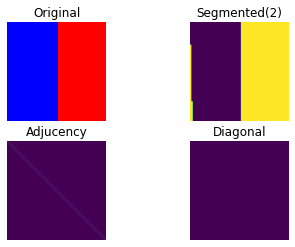

In [9]:
if __name__=='__main__':
  '''
  This program creates a color image, and segments it to given number of classes
  based on spectral clustering algorithm. 
  '''
  global numPartition

  # Create image for segmentation 
  img=createImage([70,70,3])

  # Build adjacency matrix for the Graph of the image 
  adjMatrix=createAdjMatrix(img)

  # Build diagonal matrix for the Graph of the image 
  diagMatrix=createDiagonal(adjMatrix)

  # Calculate laplacian matrix L=D-W  
  laplacianMatrix=diagMatrix-adjMatrix

  # Segment image
  LD=np.matmul(np.linalg.inv(diagMatrix),laplacianMatrix) # inv(D)*L
  eigVals, eigVecs = np.linalg.eig(LD)                    # calculate eigen values and vectors 
  
  idx=np.argsort(eigVals)                                 # sort eigen values and vectors in ascending order
  eigVals=eigVals[idx]
  eigVecs=eigVecs[:,idx]

  print('eigen values ',eigVals)
  U=np.array(eigVecs[:,1:numPartition+1])                 # reducing dimension of the eigenvector matrix to numPartition
  try:
    U.shape[1]
  except:
    U=U.reshape(U.size,1)                                 # reshaping the matrix as required by K Means function

  km=KMeans(init='k-means++',n_clusters=numPartition)     # clustering rows of eigenvector matrix using K Means
  km.fit(U)

  Y=km.labels_[:]                                         # segment image vector based on k means segmentation of eigenvector rows 
  simg=Y.reshape(img.shape[:2])                           # reshape vector to 2-D image

  # Plot the original image, segmented image, adjacency and diagonal matrices
  plt.clf()

  plt.subplot(2,2,1)                                      # original image
  plt.imshow(img[:,:,:3])
  plt.title('Original')
  plt.axis('off')

  plt.subplot(2,2,2)                                      # segmented image                            
  plt.imshow(simg)
  plt.title('Segmented('+str(numPartition)+')')
  plt.axis('off')

  plt.subplot(2,2,3)                                      # adjacency matrix
  plt.imshow(adjMatrix)
  plt.title('Adjucency')
  plt.axis('off')

  plt.subplot(2,2,4)                                      # diagonal matrix
  plt.imshow(diagMatrix)
  plt.title('Diagonal')
  plt.axis('off')

  plt.savefig('Spectral_Clustering_Results.jpg')
  plt.show()